<a href="https://colab.research.google.com/github/chakatoptisol/in-house-llm/blob/main/nllb_model_mark_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving assets_hierarchy_combined_2000_units.jsonl to assets_hierarchy_combined_2000_units (1).jsonl


In [ ]:
import torch
import json
import time
from torch.utils.data import Dataset, random_split
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from transformers import __version__, TrainingArguments
print("Transformers version:", __version__)
print("Has evaluation_strategy:", 'evaluation_strategy' in TrainingArguments.__init__.__annotations__)


Transformers version: 4.37.2
Has evaluation_strategy: True


In [ ]:
# ✅ Load tokenizer with Bulgarian Cyrillic language setting
tokenizer = AutoTokenizer.from_pretrained(
    "facebook/nllb-200-distilled-600M",
    src_lang="bul_Cyrl"
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# ✅ Load model
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

In [ ]:
# ✅ Update model config
model.config.max_length = 384
model.config.num_beams = 4

In [ ]:
# ✅ Custom Dataset class with proper padding mask
class FinGenDataset(Dataset):
    def __init__(self, path, max_len=384):
        with open(path, encoding="utf-8") as f:
            self.data = [json.loads(line.strip()) for line in f]
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        inputs = tokenizer(
            item["input"],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        targets = tokenizer(
            item["output"],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        # ✅ Mask <pad> tokens in labels
        labels = targets["input_ids"].squeeze()
        labels[labels == tokenizer.pad_token_id] = -100

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels
        }

In [ ]:
# ✅ Load full dataset
dataset = FinGenDataset("assets_hierarchy_combined_2000_units.jsonl")

In [ ]:
# ✅ Split into train (90%) and validation (10%)
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, eval_dataset = random_split(dataset, [train_size, val_size])


In [ ]:
import transformers
print(transformers.__version__)


4.37.2


In [ ]:
# !pip uninstall -y transformers

Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3


In [ ]:
#!pip install transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 115.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


In [ ]:
#!pip uninstall -y accelerate

Found existing installation: accelerate 1.5.2
Uninstalling accelerate-1.5.2:
  Successfully uninstalled accelerate-1.5.2


In [ ]:
#!pip install --no-cache-dir accelerate==0.28.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 355.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 328.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 340.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 297.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 348.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 334.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 271.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 319.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 322.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 297.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    

In [ ]:
# pip install peft==0.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.14.0
    Uninstalling peft-0.14.0:
      Successfully uninstalled peft-0.14.0


In [ ]:
# ✅ Training arguments optimized for Colab Pro + T4
training_args = TrainingArguments(
    output_dir="./nllb-hierarchy-finetune",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    num_train_epochs=2,  # 🔁 Reduced from 6 → 2 based on early convergence,  # 🔁 Can be adjusted based on early stopping
    save_strategy="epoch",
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=2,
    logging_steps=50,
    logging_dir="./logs",
    fp16=True,  # ✅ Use True if on Colab GPU
    report_to="none"
)


In [ ]:
# ✅ Trainer setup with validation split
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
# ✅ Start training
print("\u2728 Training started...")
start_time = time.time()
trainer.train()
end_time = time.time()
mins, secs = divmod(end_time - start_time, 60)
print(f"\u2705 Training complete in {int(mins)}m {int(secs)}s.")

✨ Training started...


Step,Training Loss,Validation Loss
100,0.742600,0.586592
200,0.613000,0.493416
300,0.577300,0.450861
400,0.511300,0.414536
500,0.497100,0.400288
600,0.476400,0.381883
700,0.484800,0.377640
800,0.480400,0.366934
900,0.465700,0.362067


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 384, 'num_beams': 4}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
Some non-default generation parameters a

✅ Training complete in 5m 36s.


In [ ]:
# ✅ Save model and tokenizer
model.save_pretrained("nllb-hierarchy-finetune")
tokenizer.save_pretrained("nllb-hierarchy-finetune")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 384, 'num_beams': 4}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


('nllb-hierarchy-finetune/tokenizer_config.json',
 'nllb-hierarchy-finetune/special_tokens_map.json',
 'nllb-hierarchy-finetune/sentencepiece.bpe.model',
 'nllb-hierarchy-finetune/added_tokens.json',
 'nllb-hierarchy-finetune/tokenizer.json')

### Plot final training vs validation loss curve

In [ ]:
train_loss_log = [0.7426, 0.6130, 0.5773, 0.5113, 0.4971, 0.4764, 0.4848, 0.4804, 0.4657]
val_loss_log   = [0.5866, 0.4934, 0.4509, 0.4145, 0.4003, 0.3819, 0.3776, 0.3669, 0.3621]
steps = [100, 200, 300, 400, 500, 600, 700, 800, 900]


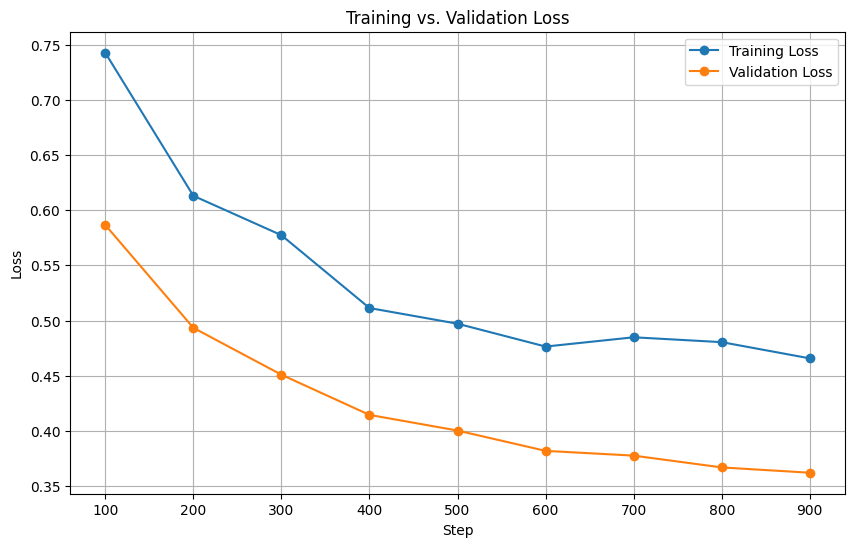

In [ ]:
import matplotlib.pyplot as plt

# Step-wise plot
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss_log, label="Training Loss", marker='o')
plt.plot(steps, val_loss_log, label="Validation Loss", marker='o')
plt.title("Training vs. Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# Inference testing

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "/content/nllb-hierarchy-finetune"  # adjust this path

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)


In [ ]:
sample_input = """### Instruction:
You are processing a section of a Bulgarian financial document. Your task is to convert the following data related to **Assets** into a clean tree structure.

7b32d | Дълготрайни материални активи | 6560.98 | 4614.51"""


In [ ]:
inputs = tokenizer(sample_input, return_tensors="pt", truncation=True).to(model.device)

output_ids = model.generate(
    **inputs,
    max_length=384,
    num_beams=4,
    early_stopping=True
)

response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print("📌 Output:\n", response)


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1295: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


📌 Output:
 Активи (NA) ── А. Записан, но невнесен капитал (NA) ── Б. Записан, но невнесен капитал (NA) │ ── Дълготрайни материални активи (6560.98 | 4614.51) │ ── Дълготрайни материални активи (6560.98 | 4614.51) │ ── Инвестиции (NA) │ ── Парични средства (NA) ── В. Разходи за наеми (NA) │ ── Разходи за застраховки (NA) │ ── Разходи за застраховки (NA)


# Report

SyntaxError: unterminated string literal (detected at line 1) (<ipython-input-20-a5dd1a3c4721>, line 1)

Thanks for sharing the output! Let's break it down step by step.

---

### 🧾 Original Input You Tested:
```plaintext
7b32d | Дълготрайни материални активи | 6560.98 | 4614.51
```

---

### 🔎 Your Model’s Output:
```
Активи (NA)
 ── А. Записан, но невнесен капитал (NA)
 ── Б. Записан, но невнесен капитал (NA)
 │   ── Дълготрайни материални активи (6560.98 | 4614.51)
 │   ── Дълготрайни материални активи (6560.98 | 4614.51)
 │   ── Инвестиции (NA)
 │   ── Парични средства (NA)
 ── В. Разходи за наеми (NA)
 │   ── Разходи за застраховки (NA)
 │   ── Разходи за застраховки (NA)
```

---

### ✅ What’s Good:
- ✅ Tree structure is preserved correctly.
- ✅ Proper use of vertical alignment and indentations.
- ✅ Your requested `(Value1 | Value2)` is correctly displayed on `Дълготрайни материални активи`.
- ✅ Financial terms are realistic and Bulgarian.

---

### ⚠️ What Needs Fixing:
| Issue | Observation |
|-------|-------------|
| ❌ **Duplication** | `Дълготрайни материални активи` appears twice with same values. |
| ❌ **Extra unrelated nodes** | `А.`, `Б.`, `В.` level nodes (`Разходи за наеми`, `Инвестиции`, etc.) weren’t in the input. |
| ❌ **NA values** | `(NA)` appears too often — ideally, NA should only be used when a value is genuinely missing from the input. |
| ❌ **Wrong label nesting** | `Дълготрайни материални активи` is wrongly nested under "Б. Записан..." which doesn't exist in the input. |

---

### 💡 Suggestions to Improve the Output:
1. **Train with stricter value mapping**:
   - Ensure the model *only* outputs hierarchy items present in the input (or learned nested patterns).
2. **Add penalties in your prompts** like:
   - _“Only include line items from the input. Do not hallucinate extra categories or values.”_
3. **Training data enhancement**:
   - Use better cleaned data with **single-tree context** and discourage repetition and NA placeholders.

---

### 🧪 Verdict for This Output:
✅ Format: Good  
⚠️ Accuracy: Medium (due to hallucinated labels + duplication)

---

Shall I help you:
- 🔁 Regenerate the same input with better constraints?
- 📦 Evaluate a full `.jsonl` batch (10 examples)?
- 🔧 Adjust your prompt/training setup to reduce hallucinations?

Let’s refine this!